In [64]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
    
import sys
sys.path.insert(0, '/home/dhruv/codebase/pyLDLE2/')
sys.path.insert(0, '..')
import numpy as np
from pyLDLE2 import util_, visualize_, datasets, buml_
from scipy.sparse import coo_matrix
from scipy import optimize
from scipy.special import erf, erfinv
from matplotlib import pyplot as plt
from scipy.stats import chi2
from scipy.sparse.linalg import svds

sys.path.insert(0, '/data2/dhruv/robust_boundary_estimation/src/')
import bx_util

seed = 42
np.random.seed(seed)
vis = visualize_.Visualize()

noise_1 = 0.01
noise_2 = 0.075
# noise_1 = 0.0
# noise_2 = 0.0
h = 0.1
k_nn = 256
d = 2

opts = bx_util.default_opts.copy()
opts['k_nn'] = k_nn
opts['h'] = h
opts['local_subspace'] = 'local_pca'

max_prctile = 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
ex_name = f'/data2/dhruv/robust_boundary_estimation/results/seed_{seed}_heteroskedastic_torus'

In [66]:
X0_, labelsMat0_, dX, q_true = datasets.Datasets().curvedtorus3d(n=15000, noise=0, density='non_uniform', seed = seed)
thresh = 0.18
mask = X0_[:,0] < thresh
X0 = X0_[mask,:]
sp_dist0 = util_.shortest_paths(X0, 5, return_predecessors=False)
q_true = q_true[mask]
labelsMat0 = labelsMat0_[mask,:]
dX = X0[:,0] > thresh-0.005
ddX = np.min(sp_dist0[dX,:], axis=0)

theta = labelsMat0[:,0]
phi = labelsMat0[:,1]
labelsMat = labelsMat0
np.save(ex_name+'_theta', theta)
np.save(ex_name+'_phi', phi)

X.shape =  (15000, 3)


In [67]:
m=2000
O_rand, _, _ = svds(np.random.normal(0,1,(m,3+1)), 3)
X_ = X0.dot(O_rand.T)

In [68]:
noise_r = noise_1 + noise_2*(1+np.cos(2*theta))/2
noise = np.random.normal(0, 1, X_.shape)
noise = noise/(np.linalg.norm(noise, axis=1)[:,None]+1e-12)
noise = noise - noise.dot(O_rand).dot(O_rand.T)
noise = noise_r[:,None]*noise
X = X_ + noise

In [69]:
print(X.shape)

(11175, 2000)


In [70]:
bx_ds_lpca, bx_init_ds_lpca, W_ds_lpca, D_ds_lpca, nu_norm_ds_lpca = bx_util.estimate_bx(X, opts=opts)
bx_ds_lpca_post = bx_util.compute_distances_from_boundary_given_boundary(X, bx_ds_lpca<np.percentile(bx_ds_lpca, max_prctile),
                                                                         k_nn=k_nn, n_pca=2)
np.save(ex_name+'_bx_ds_lpca', bx_ds_lpca_post)

Sinkhorn converged at iter: 17


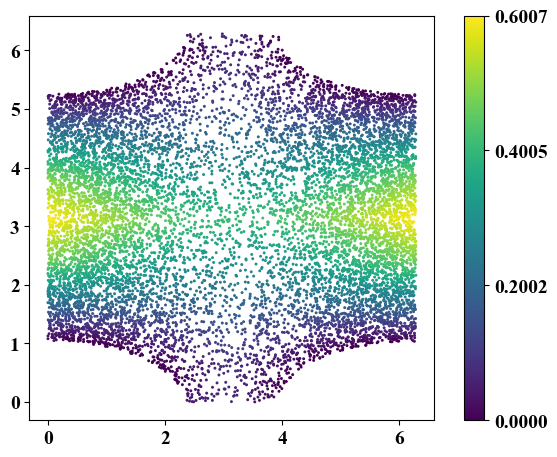

In [71]:
vis.data(labelsMat, bx_ds_lpca_post, cmap='viridis', colorbar=True)
plt.show()

In [72]:
bx_berry_sauer_w_lpca, bx_berry_sauer_init_w_lpca, K_berry_sauer_w_lpca, D_berry_sauer_w_lpca, nu_norm_berry_sauer_w_lpca = \
    bx_util.estimate_bx_berry_and_sauer(X, opts=opts)
bx_berry_sauer_w_lpca_post = bx_util.compute_distances_from_boundary_given_boundary(X, 
                                                            bx_berry_sauer_w_lpca<np.percentile(bx_berry_sauer_w_lpca, max_prctile),
                                                            k_nn=k_nn, n_pca=2)
np.save(ex_name+'_bx_berry_sauer_lpca', bx_berry_sauer_w_lpca_post)

Error at iter: 0 is: 0.08861561949032587
newton method converged at iter: 4


In [73]:
s = 8.0
u = 0.
k_nn = 1024
q_ds_lpca_w_true_ddX = bx_util.compute_q(ddX, None, h, k_nn, d, X, s=s, u=u)
q_ds_lpca = bx_util.compute_q(bx_ds_lpca_post, None, h, k_nn, d, X, s=s, u=u)
q_berry_sauer_w_lpca_w_true_ddX = bx_util.compute_q_berry_and_sauer(ddX, None, h, k_nn, d, X)
q_berry_sauer_w_lpca = bx_util.compute_q_berry_and_sauer(bx_berry_sauer_w_lpca_post, None, h, k_nn, d, X)
q_ds_lpca_no_bdry = bx_util.compute_q_wo_boundary_correction(None, h, k_nn, d, X, s=s)

np.save(ex_name+'_q_ds_lpca_w_true_ddX', q_ds_lpca_w_true_ddX)
np.save(ex_name+'_q_ds_lpca', q_ds_lpca)
np.save(ex_name+'_q_berry_sauer_w_lpca_w_true_ddX', q_berry_sauer_w_lpca_w_true_ddX)
np.save(ex_name+'_q_berry_sauer_w_lpca', q_berry_sauer_w_lpca)
np.save(ex_name+'_q_ds_lpca_no_bdry', q_ds_lpca_no_bdry)

Sinkhorn converged at iter: 17
Sinkhorn converged at iter: 17
Sinkhorn converged at iter: 17


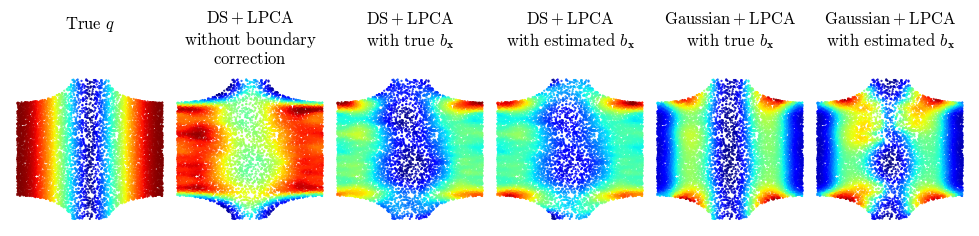

In [74]:
q_estimates = [q_true, q_ds_lpca_no_bdry, q_ds_lpca_w_true_ddX, q_ds_lpca, q_berry_sauer_w_lpca_w_true_ddX, q_berry_sauer_w_lpca]
xlabels = ['$\\text{True }q$\n\n',
           '$\\text{DS}+\\text{LPCA}$\n$\\text{without boundary}$\n$\\text{correction}$',
           '$\\text{DS}+\\text{LPCA}$\n$\\text{with true }b_\\mathbf{x}$\n',
           '$\\text{DS}+\\text{LPCA}$\n$\\text{with estimated }b_\\mathbf{x}$\n', 
           '$\\text{Gaussian}+\\text{LPCA}$\n$\\text{with true }b_\\mathbf{x}$\n',
           '$\\text{Gaussian}+\\text{LPCA}$\n$\\text{with estimated }b_\\mathbf{x}$\n']
fig_h = 1.6
n_estimates = len(q_estimates)
fig, ax = plt.subplots(1, n_estimates, figsize=(n_estimates*fig_h, 1.2*fig_h))
plt.subplots_adjust(left=0, bottom=0.2, right=1, top=1, wspace=0, hspace=0)
for i in range(n_estimates):
    ax[i].scatter(*labelsMat.T, c=q_estimates[i], cmap='jet', s=1)
    ax[i].set_title(xlabels[i], fontsize=12)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].spines[['left', 'right', 'top', 'bottom']].set_visible(False)
    #ax[i].axis('image')
#plt.tight_layout()
fig.align_titles()
plt.savefig(ex_name + '_q_figure.png', dpi=400, bbox_inches='tight')
plt.savefig('../figures/q_figure_torus.png', dpi=400, bbox_inches='tight')

In [61]:
# k_nn = 2048
# h = 0.01
# s = 2.0
# u = 1.0
# _, W_temp = bx_util.compute_q(ddX, None, h, k_nn, d, X, s=s, u=u)

In [78]:
s_list = np.arange(2, 8.1, 1)
u_list =  np.arange(0,1.1, 0.25)
# q_ds_lpca_w_true_ddX_across_s_and_u = bx_util.compute_q_across_s_and_u(ddX, W_ds_lpca, h, k_nn, opts['d'], sp_dist,
#                                                                              s_list=s_list, u_list=u_list, metric='precomputed')
q_ds_lpca_w_true_ddX_across_s_and_u = bx_util.compute_q_across_s_and_u(ddX, None, h, k_nn, opts['d'], X,
                                                                             s_list=s_list, u_list=u_list, metric='euclidean')

Sinkhorn converged at iter: 17


k_nn= 1024


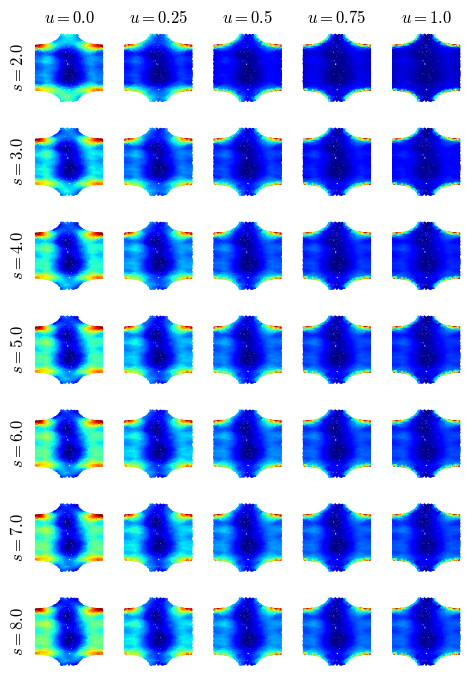

In [85]:
print('k_nn=', k_nn, flush=True)
fig_h = 1
fig, ax = plt.subplots(len(s_list), len(u_list), figsize=(len(u_list)*fig_h, len(s_list)*fig_h))
plt.subplots_adjust(left=0, bottom=0.2, right=1, top=1, wspace=0, hspace=0)
for j in range(len(u_list)):
    for i in range(len(s_list)):
        #ax[i].scatter(*labelsMat.T, c=q_estimates[i]/np.max(q_estimates[i]), cmap='jet', s=1)
        ax[i,j].scatter(*labelsMat.T, c=q_ds_lpca_w_true_ddX_across_s_and_u[0][i][j], cmap='jet', s=1)
        #ax[i].set_xlabel(xlabels[i], fontsize=12)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].spines[['left', 'right', 'top', 'bottom']].set_visible(False)
        ax[i,j].axis('image')
        if j == 0:
            ax[i,j].set_ylabel(f'$s = {s_list[i]}$', fontsize=12)
        if i == 0:
            ax[i,j].set_title(f'$u = {u_list[j]}$', fontsize=12)
plt.tight_layout()
plt.savefig(ex_name + f'_s_u_sweep_k_nn_{k_nn}.png', dpi=400)
plt.show()